In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime
import tensorflow as tf
from datetime import date, timedelta
%matplotlib inline

In [2]:
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime(2020, 1, 1)

In [3]:
bank="C"
stocks = data.DataReader(bank, 'yahoo', start, end)

In [4]:
stocks.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-12-31,483.299988,480.000000,481.299988,481.799988,547410.0,340.349487
2005-01-03,490.000000,482.000000,490.000000,482.700012,1474660.0,340.985199
2005-01-04,487.700012,477.000000,482.799988,478.600006,1584770.0,338.089020
2005-01-05,487.799988,480.200012,480.500000,484.600006,1893350.0,342.327515
2005-01-06,492.399994,487.399994,488.000000,489.299988,1804990.0,345.647675


Text(0, 0.5, 'Opening Stock Price')

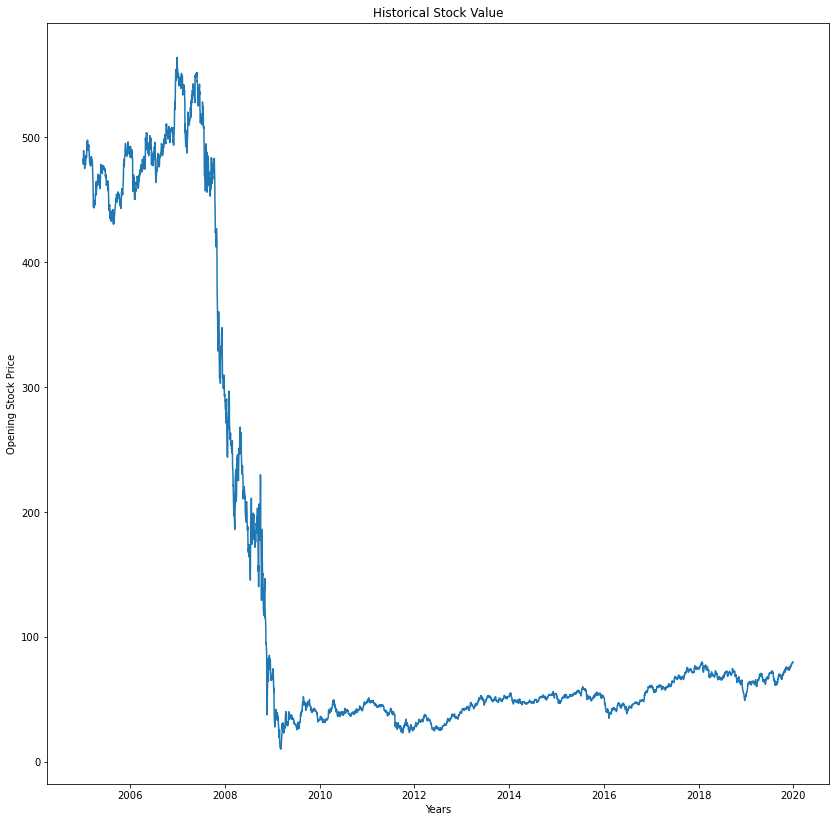

In [5]:
plt.figure(figsize=(14,14))
plt.plot(stocks['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Years')
plt.ylabel('Opening Stock Price')

In [6]:
df=stocks.reset_index()['Close']

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [8]:
train_size=int(len(df)*0.70)
test_size=len(df)-train_size
train_data=df[0:train_size]
test_data=df[train_size:]

In [9]:
def make_dataset(data,timestep):
    X=[]
    y=[]
    n=len(data)
    for i in range(0,n-timestep-1):
        X.append(data[i:i+timestep])
        y.append(data[i+timestep])
    return np.array(X),np.array(y)

In [10]:
timestep=30
X_train,y_train=make_dataset(train_data,timestep)
X_test,y_test=make_dataset(test_data,timestep)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [12]:
model=Sequential()
model.add(LSTM(40,return_sequences=True,input_shape=(timestep,1)))
model.add(LSTM(40,return_sequences=True))
model.add(LSTM(40))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam') ##Stacked LSTM

In [13]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Bidirectional
from keras.datasets import imdb 

In [14]:
modelBD = Sequential()
modelBD.add(Bidirectional(LSTM(64)))
modelBD.add(Dropout(0.5))
modelBD.add(Dense(1,activation='sigmoid'))
modelBD.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) ## Creating Bi-Directional LSTM

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 40)            6720      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 40)            12960     
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 32,681
Trainable params: 32,681
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=70,batch_size=40,verbose=1)

Epoch 1/70
66/66 [==============================] - 6s 37ms/step - loss: 0.0144 - val_loss: 2.9057e-05
Epoch 2/70
66/66 [==============================] - 2s 26ms/step - loss: 5.7528e-04 - val_loss: 8.7551e-05
Epoch 3/70
66/66 [==============================] - 2s 26ms/step - loss: 4.7289e-04 - val_loss: 6.3140e-05
Epoch 4/70
66/66 [==============================] - 2s 26ms/step - loss: 4.6578e-04 - val_loss: 8.3040e-05
Epoch 5/70
66/66 [==============================] - 2s 26ms/step - loss: 5.0667e-04 - val_loss: 4.3803e-05
Epoch 6/70
66/66 [==============================] - 2s 26ms/step - loss: 4.4371e-04 - val_loss: 6.2488e-05
Epoch 7/70
66/66 [==============================] - 2s 26ms/step - loss: 4.2450e-04 - val_loss: 3.9782e-05
Epoch 8/70
66/66 [==============================] - 2s 27ms/step - loss: 5.7899e-04 - val_loss: 4.1990e-05
Epoch 9/70
66/66 [==============================] - 2s 27ms/step - loss: 4.3399e-04 - val_loss: 2.3701e-05
Epoch 10/70
66/66 [======================

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
import math
from sklearn.metrics import mean_squared_error 

In [20]:
train_predict

array([[488.45737 ],
       [489.44754 ],
       [490.77185 ],
       ...,
       [ 56.92419 ],
       [ 56.837154],
       [ 56.57413 ]], dtype=float32)

In [21]:
test_predict

array([[57.960896],
       [57.815117],
       [57.769268],
       ...,
       [77.20636 ],
       [77.5134  ],
       [77.827675]], dtype=float32)

In [22]:
lookback=timestep
trainPlot=np.empty_like(df)
trainPlot[:,:]=np.nan
trainPlot[lookback:len(train_predict)+lookback, :]=train_predict

testPlot=np.empty_like(df)
testPlot[:, :]=np.nan
testPlot[len(train_predict)+(lookback*2)+1:len(df)-1, :]=test_predict

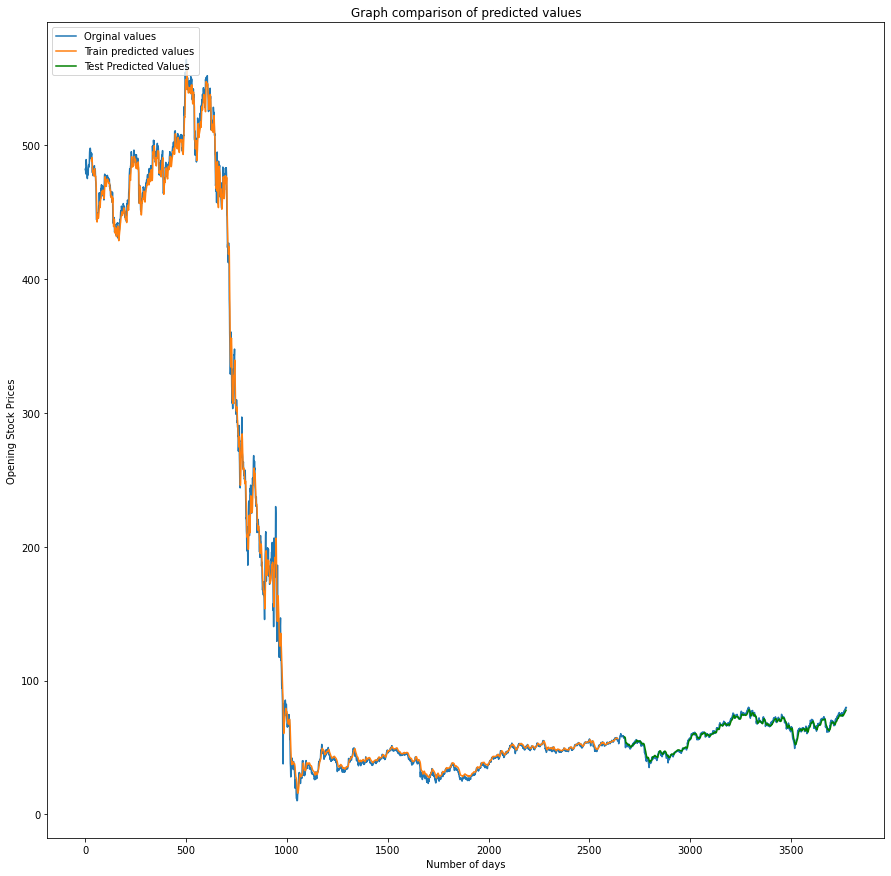

In [23]:
plt.figure(figsize=(15,15))
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPlot)
plt.plot(testPlot,color='g')
plt.title('Graph comparison of predicted values')
plt.xlabel('Number of days')
plt.ylabel('Opening Stock Prices')
plt.legend(['Orginal values','Train predicted values','Test Predicted Values'],loc=2)

In [24]:
def errorpercentage(y_test,pred):
    mape=np.mean(np.abs(y_test-pred)/y_test*100)
    return mape

In [25]:
print('Accuracy using Stacked LSTM',100-errorpercentage(scaler.inverse_transform(y_test),test_predict))

Accuracy using Stacked LSTM 97.84575715115584


In [26]:
a=test_data.shape[0]
x=test_data[a-timestep:]
scaler.inverse_transform(x)

array([[74.40000153],
       [74.81999969],
       [73.91000366],
       [73.90000153],
       [74.87000275],
       [75.68000031],
       [75.45999908],
       [75.72000122],
       [75.12000275],
       [74.51999664],
       [73.33000183],
       [74.23000336],
       [74.70999908],
       [75.80999756],
       [75.33000183],
       [75.77999878],
       [75.55000305],
       [77.05000305],
       [76.38999939],
       [76.91000366],
       [77.73999786],
       [77.91999817],
       [78.19999695],
       [78.51000214],
       [78.76000214],
       [78.58999634],
       [79.83000183],
       [79.66999817],
       [79.51000214],
       [79.88999939]])

In [27]:
x.shape

(30, 1)

In [28]:
pred_stocks = data.DataReader(bank, 'yahoo', end+timedelta(1), end+timedelta(22))## reading data for next 15 days

In [29]:
pred_stocks

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,81.260002,80.029999,80.129997,81.230003,12728900,74.407097
2020-01-03,80.519997,79.449997,79.800003,79.699997,12437400,73.005608
2020-01-06,79.550003,78.720001,78.720001,79.449997,10059500,72.776611
2020-01-07,79.300003,78.730003,79.290001,78.760002,10469100,72.144569
2020-01-08,80.000000,78.680000,78.769997,79.360001,11292400,72.694168
2020-01-09,80.980003,79.730003,80.980003,80.080002,12895900,73.353706
2020-01-10,80.010002,79.070000,80.000000,79.250000,10062100,72.593407
2020-01-13,80.720001,79.000000,79.500000,80.650002,16566300,73.875816
2020-01-14,83.110001,80.970001,81.199997,81.910004,24971800,75.029984


In [30]:
actual_values=[]
for i in pred_stocks['Close']:
    actual_values.append(i)
actual_values=np.array(actual_values)

In [31]:
actual_values

array([81.23000336, 79.69999695, 79.44999695, 78.76000214, 79.36000061,
       80.08000183, 79.25      , 80.65000153, 81.91000366, 81.23999786,
       81.        , 81.12000275, 79.90000153, 80.09999847, 79.80000305])

In [32]:
## Prediction for next 15 days
i=0
while(i<15):
    length_of_array=len(x)
    if(length_of_array==timestep):
        temp=x;
        temp=temp.reshape(1,timestep,1)
        yget=model.predict(temp)
        x=np.append(x,yget)
    else:
        temp=x[length_of_array-timestep:]
        temp=temp.reshape(1,timestep,1)
        yget=model.predict(temp)
        x=np.append(x,yget)
    i=i+1 

In [33]:
x=x.reshape(-1,1)
actual_values=actual_values.reshape(-1,1)
scaler.inverse_transform(x[timestep:])

array([[78.27681279],
       [78.23074034],
       [78.01998902],
       [77.74374416],
       [77.45844494],
       [77.18635173],
       [76.93199583],
       [76.69326428],
       [76.46639338],
       [76.24805685],
       [76.03562176],
       [75.82724752],
       [75.62167955],
       [75.4181255 ],
       [75.2162222 ]])

In [34]:
act,pred=actual_values[:i],scaler.inverse_transform(x[timestep:])

In [35]:
scaler.inverse_transform(x[timestep:])

array([[78.27681279],
       [78.23074034],
       [78.01998902],
       [77.74374416],
       [77.45844494],
       [77.18635173],
       [76.93199583],
       [76.69326428],
       [76.46639338],
       [76.24805685],
       [76.03562176],
       [75.82724752],
       [75.62167955],
       [75.4181255 ],
       [75.2162222 ]])

In [36]:
print('Accuracy for Future 15 days values',100-errorpercentage(act,pred))

Accuracy for Future 15 days values 95.68016432853466


In [37]:
from sklearn.metrics import mean_absolute_error

In [38]:
print('MSE for future 15 days values',mean_absolute_error(act,pred))

MSE for future 15 days values 3.478354721422906


In [39]:
y=len(df)-1460
Plotarr=np.empty([y+15,1])
Plotarr[::]=np.nan
Plotarr[y:]=pred

In [40]:
pred    ## stocks for the next 15 days 

array([[78.27681279],
       [78.23074034],
       [78.01998902],
       [77.74374416],
       [77.45844494],
       [77.18635173],
       [76.93199583],
       [76.69326428],
       [76.46639338],
       [76.24805685],
       [76.03562176],
       [75.82724752],
       [75.62167955],
       [75.4181255 ],
       [75.2162222 ]])

In [41]:
print('The above shows the predicted stock price for 15 days')

The above shows the predicted stock price for 15 days


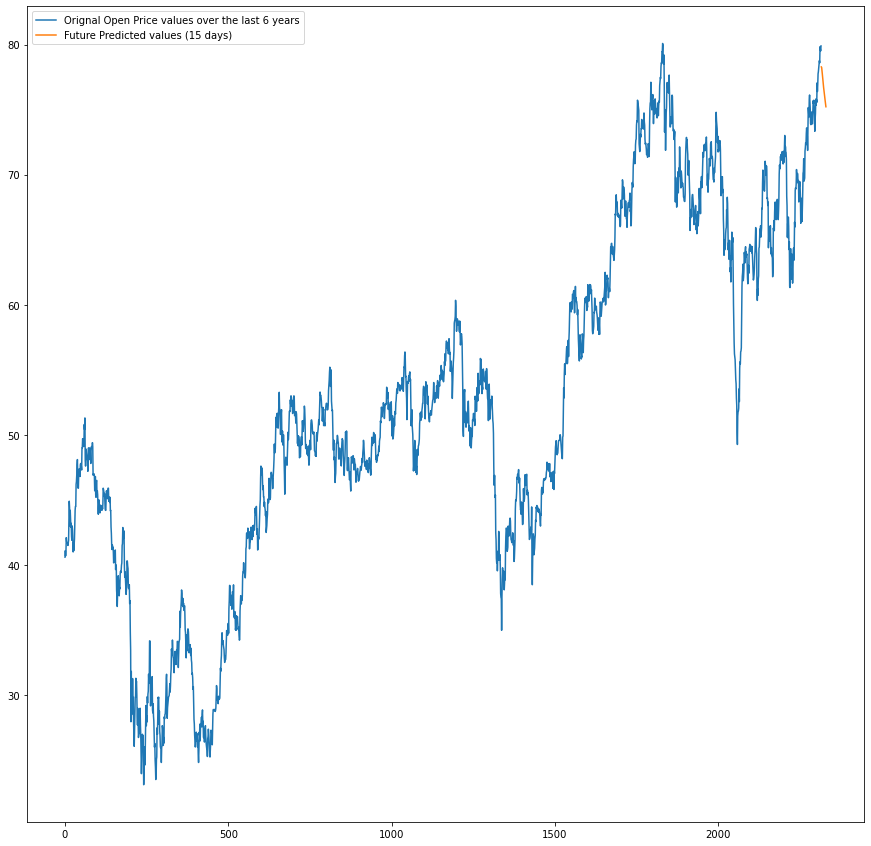

In [42]:
plt.figure(figsize=(15,15))
plt.plot(scaler.inverse_transform(df[1460:])) ## for the 
plt.plot(Plotarr)
plt.legend(['Orignal Open Price values over the last 6 years','Future Predicted values (15 days)'],loc=2)

In [43]:
f=pd.DataFrame(pred,columns=['Close'])

In [44]:
string=bank+'Data'
dfnew=pd.read_csv(string)

In [45]:
dfnew['Close']=pred

In [46]:
dfnew.to_csv(string,index=False)

In [47]:
test=pd.read_csv(string)

In [48]:
dfnew

,Close,Open
0,78.276813,79.130773
1,78.230740,79.050180
2,78.019989,78.909393
3,77.743744,78.784326
4,77.458445,78.693513
5,77.186352,78.634611
6,76.931996,78.599868
7,76.693264,78.581026
8,76.466393,78.570785
9,76.248057,78.563046


In [49]:
modelBD.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=70,batch_size=40,verbose=1)

Epoch 1/70
66/66 [==============================] - 4s 24ms/step - loss: 0.4003 - accuracy: 7.6570e-04 - val_loss: 0.3152 - val_accuracy: 0.0000e+00
Epoch 2/70
66/66 [==============================] - 1s 15ms/step - loss: 0.3140 - accuracy: 7.6570e-04 - val_loss: 0.3090 - val_accuracy: 0.0000e+00
Epoch 3/70
66/66 [==============================] - 1s 15ms/step - loss: 0.3136 - accuracy: 7.6570e-04 - val_loss: 0.3100 - val_accuracy: 0.0000e+00
Epoch 4/70
66/66 [==============================] - 1s 17ms/step - loss: 0.3122 - accuracy: 7.6570e-04 - val_loss: 0.3081 - val_accuracy: 0.0000e+00
Epoch 5/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3114 - accuracy: 7.6570e-04 - val_loss: 0.3070 - val_accuracy: 0.0000e+00
Epoch 6/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3113 - accuracy: 7.6570e-04 - val_loss: 0.3064 - val_accuracy: 0.0000e+00
Epoch 7/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3115 - accuracy: 7.6570e-04 - v

Epoch 56/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3091 - accuracy: 7.6570e-04 - val_loss: 0.3062 - val_accuracy: 0.0000e+00
Epoch 57/70
66/66 [==============================] - 1s 17ms/step - loss: 0.3089 - accuracy: 7.6570e-04 - val_loss: 0.3062 - val_accuracy: 0.0000e+00
Epoch 58/70
66/66 [==============================] - 1s 17ms/step - loss: 0.3090 - accuracy: 7.6570e-04 - val_loss: 0.3062 - val_accuracy: 0.0000e+00
Epoch 59/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3090 - accuracy: 7.6570e-04 - val_loss: 0.3063 - val_accuracy: 0.0000e+00
Epoch 60/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3090 - accuracy: 7.6570e-04 - val_loss: 0.3063 - val_accuracy: 0.0000e+00
Epoch 61/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3089 - accuracy: 7.6570e-04 - val_loss: 0.3063 - val_accuracy: 0.0000e+00
Epoch 62/70
66/66 [==============================] - 1s 16ms/step - loss: 0.3093 - accuracy: 7.6570e

In [50]:
train_predict=modelBD.predict(X_train)
test_predict=modelBD.predict(X_test)

In [51]:
trypredict=scaler.inverse_transform(test_predict)

In [52]:
trypredict

array([[55.02656 ],
       [55.004227],
       [55.000893],
       ...,
       [70.80179 ],
       [71.06066 ],
       [71.28939 ]], dtype=float32)

In [53]:
print('Accuracy using Bi-directional LSTM',100-errorpercentage(scaler.inverse_transform(y_test),trypredict))

Accuracy using Bi-directional LSTM 93.5036020976465
